In [4]:
from qiskit import (
    QuantumRegister,
    ClassicalRegister,
    QuantumCircuit,
    execute,
    Aer
)
from qiskit.visualization import plot_histogram

In [54]:
dualcz_reg = QuantumRegister(2)
dczc = QuantumCircuit(dualcz_reg, name="dczc")
dczc.h(0)
dczc.cx(0,1)
dczc.h(0)

dualcz = dczc.to_instruction()
    
# extract syndromes for two-bit [[5,1,3]] QEC scheme
esr = QuantumRegister(5, 'q')
esra = QuantumRegister(1, 'a')
esrc = ClassicalRegister(4, 'c')
esc = QuantumCircuit(esr, esra, esrc, name="esc")

for i in range(4):
    esc.append(dualcz, [esr[i], esra[0]])
    esc.cz(esr[(i+1)%5], esra[0])
    esc.cz(esr[(i+2)%5], esra[0])
    esc.append(dualcz, [esr[(i+3)%5], esra[0]])
    esc.measure([esra[0]],[esrc[i]])

extract_syndromes = esc.to_instruction()
        

def build_syndrome(qc, qr, anc, cr, n):
    qc.h(anc[1])
    qc.append(dualcz,[qr[(n)%5],anc[0]])
    qc.cx(anc[1],anc[0])
    qc.cx(qr[(1+n)%5],anc[0])
    qc.cx(qr[(2+n)%5],anc[0])
    qc.cx(anc[1],anc[0])
    qc.append(dualcz,[qr[(3+n)%5],anc[0]])
    qc.h(anc[1])
    qc.measure([anc[0]],[cr[0]])
    qc.measure([anc[1]],[cr[1]])
    return qc
    
    
    
simulator = Aer.get_backend('qasm_simulator')    

qr = QuantumRegister(5, 'q')
anc0 = QuantumRegister(2, 'a0')
cr0 = ClassicalRegister(2, 'c0')

def run_syndrome(qr, anc, cr, n):

    syndrome = QuantumCircuit(qr, anc, cr)

    build_syndrome(syndrome, qr, anc, cr, n)

    job = execute(syndrome, simulator, shots=1)
    result = job.result()
    counts = result.get_counts(syndrome)

    flags = ([*counts][0])
    
    print("Error syndrome and flag for syndrome", n, ": ", flags)

    if flags == '00':
        if n == 3:
            return 0
        else:
            return run_syndrome(qr, QuantumRegister(2, 'a' + str(n+1)), ClassicalRegister(2, 'c' + str(n+1)), n+1)
    
    else:
        ancE = QuantumRegister(1, 'aE')
        crE = ClassicalRegister(4, 'cE')
        
        extract = QuantumCircuit(qr, ancE, crE)
        extract.append(extract_syndromes, [qr[0], qr[1], qr[2], qr[3], qr[4], ancE[0]], [crE[0], crE[1], crE[2], crE[3]])
        
        job = execute(extract, simulator, shots=1)
        result = job.result()
        counts = result.get_counts(extract)
        
        syndrome_code = ([*counts][0])
        
        print("Syndrome code: ", syndrome_code)
        
        fixer = QuantumCircuit(qr)
        
        if flags == '10':
            
            if syndrome_code == '0001':
                fixer.x(qr[0])
            if syndrome_code == '1011':
                fixer.x(qr[0])
                fixer.z(qr[0])
            if syndrome_code == '1010':
                fixer.z(qr[0])
            if syndrome_code == '1000':
                fixer.x(qr[1])
            if syndrome_code == '1101':
                fixer.x(qr[1])
                fixer.z(qr[1])
            if syndrome_code == '0101':
                fixer.z(qr[1])
            if syndrome_code == '1100':
                fixer.x(qr[2])
            if syndrome_code == '1110':
                fixer.x(qr[2])
                fixer.z(qr[2])
            if syndrome_code == '0010':
                fixer.z(qr[2])
            if syndrome_code == '0110':
                fixer.x(qr[3])
            if syndrome_code == '1111':
                fixer.x(qr[3])
                fixer.z(qr[3])
            if syndrome_code == '1001':
                fixer.z(qr[3])
            if syndrome_code == '0011':
                fixer.x(qr[4])
            if syndrome_code == '0111':
                fixer.x(qr[4])
                fixer.z(qr[4])
            if syndrome_code == '0100':
                fixer.z(qr[4])
                
        else:
            
            if n == 0:
                
                if syndrome_code == '0001':
                    fixer.x(qr[0])
                if syndrome_code == '0100':
                    fixer.x(qr[3])
                    fixer.z(qr[2])
                if syndrome_code == '0110':
                    fixer.x(qr[3])
                if syndrome_code == '1000':
                    fixer.x(qr[2])
                    fixer.x(qr[3])
                    fixer.z(qr[2])
                if syndrome_code == '1001':
                    fixer.x(qr[0])
                    fixer.x(qr[1])
                if syndrome_code == '1010':
                    fixer.x(qr[2])
                    fixer.x(qr[3])
                if syndrome_code == '1100':
                    fixer.x(qr[3])
                    fixer.x(qr[4])
                    fixer.z(qr[3])
                
            if n == 1:
                
                if syndrome_code == '0011':
                    fixer.x(qr[4])
                if syndrome_code == '0100':
                    fixer.x(qr[1])
                    fixer.x(qr[2])
                if syndrome_code == '0101':
                    fixer.x(qr[3])
                    fixer.x(qr[4])
                if syndrome_code == '0110':
                    fixer.x(qr[0])
                    fixer.x(qr[4])
                    fixer.z(qr[4])
                if syndrome_code == '1000':
                    fixer.x(qr[1])
                if syndrome_code == '1010':
                    fixer.x(qr[4])
                    fixer.z(qr[3])
                if syndrome_code == '1100':
                    fixer.x(qr[3])
                    fixer.x(qr[4])
                    fixer.z(qr[3])
                
            if n == 2:
                
                if syndrome_code == '0001':
                    fixer.x(qr[0])
                if syndrome_code == '0010':
                    fixer.x(qr[0])
                    fixer.x(qr[4])
                if syndrome_code == '0011':
                    fixer.x(qr[0])
                    fixer.x(qr[1])
                    fixer.z(qr[0])
                if syndrome_code == '0101':
                    fixer.x(qr[0])
                    fixer.z(qr[4])
                if syndrome_code == '0110':
                    fixer.x(qr[0])
                    fixer.x(qr[4])
                    fixer.x(qr[4])
                if syndrome_code == '1010':
                    fixer.x(qr[2])
                    fixer.x(qr[3])
                if syndrome_code == '1100':
                    fixer.x(qr[2])
                
            if n == 3:
                
                if syndrome_code == '0001':
                    fixer.x(qr[3])
                    fixer.x(qr[4])
                    fixer.z(qr[4])
                if syndrome_code == '0010':
                    fixer.x(qr[1])
                    fixer.z(qr[0])
                if syndrome_code == '0011':
                    fixer.x(qr[0])
                    fixer.x(qr[1])
                    fixer.z(qr[0])
                if syndrome_code == '0101':
                    fixer.x(qr[3])
                    fixer.x(qr[4])
                if syndrome_code == '0110':
                    fixer.x(qr[3])
                if syndrome_code == '1000':
                    fixer.x(qr[1])
                if syndrome_code == '1001':
                    fixer.x(qr[0])
                    fixer.x(qr[1])
                
                
        return 1

error_detected = run_syndrome(qr, anc0, cr0, 0)

if error_detected:
    print("Error detected and fixed.")
else:
    print("No error detected.")



Error syndrome and flag for syndrome 0 :  01
Syndrome code:  0110
Error detected and fixed.


# Syndrome 1 Extraction Circuit

In [45]:
def build_syndrome(qc, qr, anc, cr, n):
    qc.h(anc[1])
    qc.append(dualcz,[qr[(n)%5],anc[0]])
    qc.cx(anc[1],anc[0])
    qc.cx(qr[(1+n)%5],anc[0])
    qc.cx(qr[(2+n)%5],anc[0])
    qc.cx(anc[1],anc[0])
    qc.append(dualcz,[qr[(3+n)%5],anc[0]])
    qc.h(anc[1])
    qc.measure([anc[0]],[cr[0]])
    qc.measure([anc[1]],[cr[1]])
    return qc

qr = QuantumRegister(5, 'q')
anc0 = QuantumRegister(2, 'a0')
cr0 = ClassicalRegister(2, 'c0')
qc=QuantumCircuit(qr,anc0,cr0)
syndrome = QuantumCircuit(qr, anc0, cr0)

build_syndrome(syndrome, qr, anc0, cr0, 1)
qc.decompose().draw(output='mpl')

MissingOptionalLibraryError: "The 'pylatexenc' library is required to use 'MatplotlibDrawer'. You can install it with 'pip install pylatexenc'."

# Error Syndrome Extraction Circuit

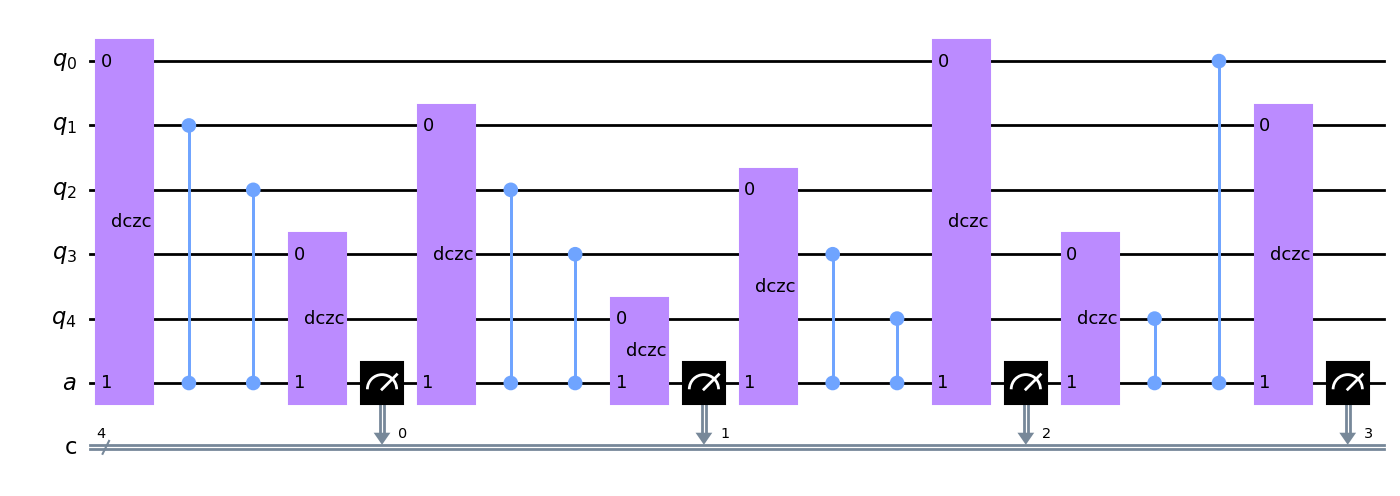

In [ ]:
qr = QuantumRegister(5, 'q')
anc = QuantumRegister(1, 'a')
cr = ClassicalRegister(4, 'c')
        
extract = QuantumCircuit(qr, anc, cr)
extract.append(extract_syndromes, [qr[0], qr[1], qr[2], qr[3], qr[4], anc[0]], [cr[0], cr[1], cr[2], cr[3]])
        
extract.decompose().draw()